In [1]:
# Basic data analysis
import pandas as pd
import numpy as np
import missingno as msno

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

# Automatic data analysis
from ydata_profiling import ProfileReport
# Statistics
from scipy import stats
import distfit 
from distfit import distfit

from tqdm import tqdm

In [2]:
df_train = pd.read_csv("../data/EDA_export/train.csv")
df_test = pd.read_csv("../data/EDA_export/test.csv")

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   VIP           8490 non-null   object 
 5   RoomService   8512 non-null   float64
 6   FoodCourt     8510 non-null   float64
 7   ShoppingMall  8485 non-null   float64
 8   Spa           8510 non-null   float64
 9   VRDeck        8505 non-null   float64
 10  Transported   8693 non-null   int64  
 11  Cabin_deck    8494 non-null   object 
 12  Cabin_side    8494 non-null   object 
 13  ID_group      8693 non-null   int64  
 14  ID_num        8693 non-null   int64  
 15  Group_size    8693 non-null   int64  
dtypes: float64(6), int64(4), object(6)
memory usage: 1.1+ MB


<a id="1"></a>
# 1 Imputation based on observations from EDA

### 1.1 Impute missing expense with 0 for those who were cryosleeping

In [10]:
expenses = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

In [5]:
df_train.loc[df_train["CryoSleep"]==True, expenses] = df_train.loc[df_train["CryoSleep"]==True, expenses].fillna(0)

### 1.2 Impute missing VIP with False since for those from Earth and those no older than 18

In [6]:
df_train.loc[(df_train["HomePlanet"]=="Earth") | (df_train["Age"]<=18) , "VIP"] = False

### 1.3 Impute missing expenses with 0 for anyone no older than 12

In [7]:
df_train.loc[df_train["Age"]<=12, expenses] = df_train.loc[df_train["Age"]<=12, expenses].fillna(0)

### 1.4 Impute missing HomePlanet based on Cabin_deck

<font size="4"> Some easy observations:

- Passengers living on deck A, B and C are 100% from Europa
- None of the passengers living on deck D is from Earth
- None of the passengers living on deck F is from Europa
- Passengers living on deck G are 100% from Earth
- Passengers living on deck T are 100% from Europa, and it seems that deck T accommodated very few passengers
- Passengers from Mars only lived on deck D, E and F
- Passengers from Earth only lived on deck E, F and G
</font>

In [8]:
df_train.loc[df_train["Cabin_deck"].isin(["A", "B", "C", "T"]), "HomePlanet"] = df_train.loc[df_train["Cabin_deck"].isin(["A", "B", "C", "T"]), "HomePlanet"].fillna("Europa")

In [9]:
df_train.loc[df_train["Cabin_deck"] == "G", "HomePlanet"] = df_train.loc[df_train["Cabin_deck"] == "G", "HomePlanet"].fillna("Earth")

### 1.4 Impute missing HomePlanet and Cabin_side with each group since they take unique value in every group

In [10]:
# Fill in the missing values in "HomePlanet" and "cabin_side" for any groups with at least 2 passengers with the same value as that of the other group members if not all of theirs are missing
df_train = df_train.merge(df_train.groupby("ID_group")["HomePlanet"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index(), on='ID_group')
df_train = df_train.merge(df_train.groupby("ID_group")["Cabin_side"].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan).reset_index(), on='ID_group')
df_train.drop(columns=['HomePlanet_x', 'Cabin_side_x'], inplace=True)
df_train.rename(columns={'HomePlanet_y': 'HomePlanet', 'Cabin_side_y': 'Cabin_side'}, inplace=True)

### 1.4 Impute missing HomePlanet with Europa for who spent over a total of 2500 in FoodCourt, VRDeck and Spa

In [11]:
# Step 1: Calculate the condition and get indices
condition = (df_train["FoodCourt"] + df_train["VRDeck"] + df_train["Spa"] > 2500)
indices = df_train[condition].index

# Step 2: Use loc to modify "HomePlanet" safely
df_train.loc[indices, "HomePlanet"] = df_train.loc[indices, "HomePlanet"].fillna("Europa")

In [12]:
# Drop ID_group
df_train = df_train.drop(columns="ID_group")

<a id="2"></a>
# 2 Imputation the remaining missing values with CatBoost

In [13]:
from catboost import CatBoostClassifier, CatBoostRegressor

In [14]:
import logging
import sys

# Create or get the logger
logger = logging.getLogger()  # Root logger
if not logger.handlers:
    # Set level and create handler
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler(sys.stdout)
    
    # Create formatter and add it to the handler
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    
    # Add handler to the logger
    logger.addHandler(handler)


In [15]:
label = "Transported"

In [16]:
missing_cat = [feature for feature in df_train.columns if df_train[feature].dtype == "O" and df_train[feature].isna().sum()>0 and feature != label]

In [17]:
missing_num = [feature for feature in df_train.columns if df_train[feature].dtype != "O" and df_train[feature].isna().sum()>0 and feature != label]

In [18]:
def missing_index(df, features):
    missing_row_index = {}
    
    for feature in features:
        missing_row_index[feature] = df[df[feature].isna()].index

    return missing_row_index

In [19]:
def get_features(df: pd.DataFrame = None, missing_type: str = "cat", label: str = None):
    
    if missing_type == "cat":
        features = [feature for feature in df.columns if df[feature].dtype == "O" and df[feature].isna().sum() > 0 and feature != label]
    elif missing_type == "num": 
        features = [feature for feature in df.columns if df[feature].dtype != "O" and df[feature].isna().sum() > 0 and feature != label]
    else: 
        raise TypeError(f"The missing_type you gave is {missing_type}, but it can only be 'cat' or 'num'!")
    
    return features

In [20]:
def fill_placeholder(df: pd.DataFrame = None, features: list = None):
    
    for feature in features:
        if df[feature].dtype == "O":
            df[feature] = df[feature].fillna(f"Missing_{feature}")
        elif df[feature].dtype != "O":
            df[feature] = df[feature].fillna(df[feature].median())
        else: 
            raise TypeError(f"The missing_type you gave is {missing_type}, but it can only be 'cat' or 'num'!")
    
    return df

<a id="2.1"></a>
## 2.1 Imputation the remaining missing values for categorical features with CatBoost

In [21]:
from tqdm import tqdm
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import hamming_loss, mean_squared_error

In [33]:
cat_params={
             'depth': 7,
             'learning_rate': 0.1,
             'l2_leaf_reg': 0.7,
             'random_strength': 0.2,
             'max_bin': 200,
             'od_wait': 65,
             'one_hot_max_size': 70,
             'grow_policy': 'Depthwise',
             'bootstrap_type': 'Bayesian',
             'od_type': 'Iter',
             'eval_metric': 'MultiClass',
             'loss_function': 'MultiClass',
             'verbose': True
           }

num_params = {
            'iterations': 500,
            'depth': 6,
            'learning_rate': 0.02,
            'l2_leaf_reg': 0.5,
            'random_strength': 0.2,
            'max_bin': 150,
            'od_wait': 80,
            'one_hot_max_size': 70,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bayesian',
            'od_type': 'IncToDec',
            'eval_metric': 'RMSE',
            'loss_function': 'RMSE',
            'random_state': 42,
            'verbose': True
        }

In [27]:
class iter_cv_catboost_imputer(BaseEstimator, TransformerMixin):
    """
    Note that dataset used to train the imputer and the dataset to be imputed must have exactly the same features.

    Always first train the imputer before imputing another dataset using "transform" method

    """

    def __init__(
        self,
        label: str = None,
        max_iter: int = 10,
        n_splits: int = 5,
        cat_hyperparams: dict = None,
        num_hyperparams: dict = None,
    ):
        self.label = label
        self.max_iter = max_iter
        self.n_splits = n_splits
        self.cat_hyperparams = cat_hyperparams if cat_hyperparams is not None else {}
        self.num_hyperparams = num_hyperparams if num_hyperparams is not None else {}
        self.cat_features = None
        self.num_features = None
        self.imp_features = None
        self.cat_imp_features = None
        self.num_imp_features = None
        self.estimators = None
        self.label_encoders = None
        self.errors = None

    def fit(self, train: pd.DataFrame):
        logging.info("Starting the fitting process.")
        # Get all the categorical and numerical features respectively in the training set
        self.cat_features = [
            feature for feature in train.columns if train[feature].dtype == "O" and feature != self.label
        ]
        self.num_features = [
            feature for feature in train.columns if train[feature].dtype != "O" and feature != self.label
        ]
        # Get features to be imputed
        self.cat_imp_features = get_features(train, missing_type="cat", label=self.label)
        self.num_imp_features = get_features(train, missing_type="num", label=self.label)
        self.imp_features = self.cat_imp_features + self.num_imp_features
        logging.info(f"Identified categorical features to impute: {self.cat_imp_features}")
        logging.info(f"Identified numerical features to impute: {self.num_imp_features}")
        # Get the indices of the rows with missing values for every feature to be imputed
        missing_rows = missing_index(train, self.imp_features)

        # First, fill the missing values with the appropriate placeholder
        train = fill_placeholder(df=train, features=self.imp_features)

        # Second, we drop the label (the label for our ML task, not the label in each imputation iteration) from the dataset
        train = train.drop(columns=self.label)

        # Initialize the estimator, error and label encoder dictionaries to save the error/difference in each iteration to monitor our training process
        estimators = {feature: [] for feature in self.imp_features}
        errors = {feature: [] for feature in self.imp_features}
        label_encoders = {feature: [] for feature in self.cat_imp_features}

        # Third, we start training and then impute the missing values in the training set iteratively
        for i in tqdm(range(self.max_iter), desc="Iterations"):
            for feature in self.imp_features:

                logging.info(f"Starting iteration {i+1} for feature: {feature}")
                print(f"Starting iteration {i+1} for feature: {feature}")
                # Set up imputation training and test sets specifically for the current feature
                test_curr = train.iloc[missing_rows[feature]]
                train_curr = train.drop(index=missing_rows[feature])
                # Define the imputation label as the current feature to be imputed and the features (especially the categorical features) to be the remaining features
                label_curr = feature
                features_curr = [feature_curr for feature_curr in self.imp_features if feature_curr != label_curr]
                cat_features_curr = [
                    feature_curr for feature_curr in self.cat_imp_features if feature_curr != label_curr
                ]
                # Define X and Y in train_curr for the current feature, apply label encoding to Y if label_curr is categorical
                X_curr = train_curr.loc[:, features_curr]
                Y_curr = train_curr.loc[:, label_curr]
                if label_curr in self.cat_imp_features:
                    label_encoder = LabelEncoder()
                    Y_curr = pd.Series(label_encoder.fit_transform(Y_curr), index=Y_curr.index)
                # Define X in test_curr for the current feature which will be used in prediction
                X_test_curr = test_curr.loc[:, features_curr]

                # Select the appropriate cross-validation technique
                if feature in self.cat_imp_features:
                    cv = StratifiedKFold(n_splits=self.n_splits)
                else:
                    cv = KFold(n_splits=self.n_splits)
                # Initialize the list of the fitted estimator from different cv folds for the current feature in the current iteration
                estimators_curr = []
                # Start cross-validation training
                for train_index, _ in cv.split(X_curr, Y_curr):

                    logging.info(f"Starting new cv fold for feature: {label_curr}")
                    # Define the X and Y for both training folds (the test fold is useless here)
                    X_train, Y_train = X_curr.iloc[train_index], Y_curr.iloc[train_index]
                    # Define Catboost estimator based on the type of the current feature to be imputed)
                    estimator_curr = (
                        CatBoostClassifier(**self.cat_hyperparams)
                        if label_curr in self.cat_imp_features
                        else CatBoostRegressor(**self.num_hyperparams)
                    )
                    # Fit the Catboost estimator and append it to the list "estimators_curr"
                    estimator_curr.fit(X_train, Y_train, cat_features=cat_features_curr, verbose=False)
                    estimators_curr.append(estimator_curr)
                    logging.info(f"Completed new cv fold for feature: {label_curr}")
                # Predict the missing values of the current feature to be impute by first averaging the prediction from different folds
                Y_pred = np.mean(
                    np.array(
                        [
                            (
                                estimator.predict_proba(X_test_curr)
                                if label_curr in self.cat_imp_features
                                else estimator.predict(X_test_curr)
                            )
                            for estimator in estimators_curr
                        ]
                    ),
                    axis=0,
                )
                # If the feature to be imputed is categorical, we need to pick the category with the highest average probability as our prediction
                if label_curr in self.cat_imp_features:
                    Y_pred = pd.Series(
                        label_encoder.inverse_transform(np.argmax(Y_pred, axis=1)), index=test_curr.index
                    )
                # Fill the prediction into the training set
                Y_pred_prev = test_curr.loc[:, label_curr]
                train.loc[missing_rows[label_curr], label_curr] = Y_pred
                logging.info(f"Updated feature '{feature}' with imputed values.")
                print(f"Updated feature '{feature}' with imputed values.")
                # Calculate the difference between the imputed values of label_curr from two consecutive iterations
                if i > 0:
                    (
                        errors[label_curr].append(
                            hamming_loss(Y_pred_prev.astype("category"), Y_pred.astype("category"))
                        )
                        if label_curr in self.cat_imp_features
                        else errors[label_curr].append(np.sqrt(mean_squared_error(Y_pred_prev, Y_pred)))
                    )
                # Finally, we need to save all the label encoders and the estimators in the final iteration so that we can use it to impute the other dataset, say the validation and the test set of ML task
                if i == self.max_iter - 1:
                    estimators[label_curr] = estimators_curr
                    if label_curr in self.cat_imp_features:
                        label_encoders[label_curr] = label_encoder
                logging.info("Completed the fitting process.")
                print("Completed the fitting process.")
        self.errors = errors
        self.estimators = estimators
        self.label_encoders = label_encoders

        return self

    def plot_training_error(self):
        for feature, values in self.errors.items():
            iterations = range(1, len(values) + 1)  # x-axis values (iterations)
            plt.plot(iterations, values, label=feature)  # plot the values
            plt.xlabel("Iterations")
            plt.ylabel("Errors")
            plt.title(
                "Minimization of Error (Hamming loss for categorical features and RMSE for numerical features) with iterations"
            )
            plt.legend()
            plt.show()

    def transform(self, test: pd.DataFrame):
        # First, ensure the test set has the exact same categorical and numerical features as the training set
        test_cat_features = [
            feature for feature in test.columns if test[feature].dtype == "O" and feature != self.label
        ]
        test_num_features = [
            feature for feature in test.columns if test[feature].dtype != "O" and feature != self.label
        ]

        if set(test_cat_features) != set(self.cat_features) or set(test_num_features) != set(self.num_features):
            raise ValueError(
                "The features in the test set do NOT match those in the training set. Check both categorical and numerical features."
            )

        # Second, get the indices of the rows with missing values for every feature to be imputed
        missing_rows = missing_index(test, self.imp_features)

        # Third, fill the missing values with the appropriate placeholder
        test = fill_placeholder(df=test, features=self.imp_features)

        # Finally, we start to fill the missing values with the saved estimators we obtained from training
        for feature in self.imp_features:
            if missing_rows[feature].any():
                X_curr = test.loc[missing_rows[feature], [f for f in self.imp_features if f != feature]]
                if feature in self.cat_imp_features:
                    predictions = np.array([estimator.predict_proba(X_curr) for estimator in self.estimators[feature]])
                    Y_curr_pred = np.mean(predictions, axis=0)
                    Y_curr_pred = self.label_encoders[feature].inverse_transform(np.argmax(Y_curr_pred, axis=1))
                else:
                    predictions = np.array([estimator.predict(X_curr) for estimator in self.estimators[feature]])
                    Y_curr_pred = np.mean(predictions, axis=0)

            test.loc[missing_rows[feature], feature] = Y_curr_pred

        return test

    def fit_transform(self, train: pd.DataFrame) -> pd.DataFrame:
        self.fit(train)
        return train

      
         

In [28]:
Imputer = iter_cv_catboost_imputer(label="Transported", max_iter=15)

In [29]:
df_train_cp = df_train.copy()

In [30]:
Imputer.fit_transform(df_train_cp)

Iterations:   0%|                                                                                                                                                                                         | 0/15 [00:00<?, ?it/s]

Starting iteration 1 for feature: CryoSleep
Updated feature 'CryoSleep' with imputed values.
Completed the fitting process.
Starting iteration 1 for feature: Destination
Updated feature 'Destination' with imputed values.
Completed the fitting process.
Starting iteration 1 for feature: VIP
Updated feature 'VIP' with imputed values.
Completed the fitting process.
Starting iteration 1 for feature: Cabin_deck
Updated feature 'Cabin_deck' with imputed values.
Completed the fitting process.
Starting iteration 1 for feature: HomePlanet
Updated feature 'HomePlanet' with imputed values.
Completed the fitting process.
Starting iteration 1 for feature: Cabin_side
Updated feature 'Cabin_side' with imputed values.
Completed the fitting process.
Starting iteration 1 for feature: Age
Updated feature 'Age' with imputed values.
Completed the fitting process.
Starting iteration 1 for feature: RoomService
Updated feature 'RoomService' with imputed values.
Completed the fitting process.
Starting iteration

Iterations:   7%|███████████▌                                                                                                                                                                  | 1/15 [13:51<3:13:55, 831.13s/it]

Updated feature 'VRDeck' with imputed values.
Completed the fitting process.
Starting iteration 2 for feature: CryoSleep
Updated feature 'CryoSleep' with imputed values.
Completed the fitting process.
Starting iteration 2 for feature: Destination
Updated feature 'Destination' with imputed values.
Completed the fitting process.
Starting iteration 2 for feature: VIP
Updated feature 'VIP' with imputed values.
Completed the fitting process.
Starting iteration 2 for feature: Cabin_deck
Updated feature 'Cabin_deck' with imputed values.
Completed the fitting process.
Starting iteration 2 for feature: HomePlanet
Updated feature 'HomePlanet' with imputed values.
Completed the fitting process.
Starting iteration 2 for feature: Cabin_side
Updated feature 'Cabin_side' with imputed values.
Completed the fitting process.
Starting iteration 2 for feature: Age
Updated feature 'Age' with imputed values.
Completed the fitting process.
Starting iteration 2 for feature: RoomService
Updated feature 'RoomSe

Iterations:  13%|███████████████████████▏                                                                                                                                                      | 2/15 [27:13<2:56:26, 814.33s/it]

Updated feature 'VRDeck' with imputed values.
Completed the fitting process.
Starting iteration 3 for feature: CryoSleep
Updated feature 'CryoSleep' with imputed values.
Completed the fitting process.
Starting iteration 3 for feature: Destination
Updated feature 'Destination' with imputed values.
Completed the fitting process.
Starting iteration 3 for feature: VIP
Updated feature 'VIP' with imputed values.
Completed the fitting process.
Starting iteration 3 for feature: Cabin_deck
Updated feature 'Cabin_deck' with imputed values.
Completed the fitting process.
Starting iteration 3 for feature: HomePlanet
Updated feature 'HomePlanet' with imputed values.
Completed the fitting process.
Starting iteration 3 for feature: Cabin_side
Updated feature 'Cabin_side' with imputed values.
Completed the fitting process.
Starting iteration 3 for feature: Age
Updated feature 'Age' with imputed values.
Completed the fitting process.
Starting iteration 3 for feature: RoomService
Updated feature 'RoomSe

Iterations:  20%|██████████████████████████████████▊                                                                                                                                           | 3/15 [40:25<2:40:48, 804.05s/it]

Updated feature 'VRDeck' with imputed values.
Completed the fitting process.
Starting iteration 4 for feature: CryoSleep
Updated feature 'CryoSleep' with imputed values.
Completed the fitting process.
Starting iteration 4 for feature: Destination
Updated feature 'Destination' with imputed values.
Completed the fitting process.
Starting iteration 4 for feature: VIP
Updated feature 'VIP' with imputed values.
Completed the fitting process.
Starting iteration 4 for feature: Cabin_deck
Updated feature 'Cabin_deck' with imputed values.
Completed the fitting process.
Starting iteration 4 for feature: HomePlanet
Updated feature 'HomePlanet' with imputed values.
Completed the fitting process.
Starting iteration 4 for feature: Cabin_side
Updated feature 'Cabin_side' with imputed values.
Completed the fitting process.
Starting iteration 4 for feature: Age
Updated feature 'Age' with imputed values.
Completed the fitting process.
Starting iteration 4 for feature: RoomService
Updated feature 'RoomSe

Iterations:  27%|██████████████████████████████████████████████▍                                                                                                                               | 4/15 [54:38<2:30:55, 823.26s/it]

Updated feature 'VRDeck' with imputed values.
Completed the fitting process.
Starting iteration 5 for feature: CryoSleep
Updated feature 'CryoSleep' with imputed values.
Completed the fitting process.
Starting iteration 5 for feature: Destination
Updated feature 'Destination' with imputed values.
Completed the fitting process.
Starting iteration 5 for feature: VIP
Updated feature 'VIP' with imputed values.
Completed the fitting process.
Starting iteration 5 for feature: Cabin_deck
Updated feature 'Cabin_deck' with imputed values.
Completed the fitting process.
Starting iteration 5 for feature: HomePlanet
Updated feature 'HomePlanet' with imputed values.
Completed the fitting process.
Starting iteration 5 for feature: Cabin_side
Updated feature 'Cabin_side' with imputed values.
Completed the fitting process.
Starting iteration 5 for feature: Age
Updated feature 'Age' with imputed values.
Completed the fitting process.
Starting iteration 5 for feature: RoomService
Updated feature 'RoomSe

Iterations:  33%|█████████████████████████████████████████████████████████▎                                                                                                                  | 5/15 [1:08:44<2:18:36, 831.62s/it]

Updated feature 'VRDeck' with imputed values.
Completed the fitting process.
Starting iteration 6 for feature: CryoSleep
Updated feature 'CryoSleep' with imputed values.
Completed the fitting process.
Starting iteration 6 for feature: Destination
Updated feature 'Destination' with imputed values.
Completed the fitting process.
Starting iteration 6 for feature: VIP
Updated feature 'VIP' with imputed values.
Completed the fitting process.
Starting iteration 6 for feature: Cabin_deck
Updated feature 'Cabin_deck' with imputed values.
Completed the fitting process.
Starting iteration 6 for feature: HomePlanet
Updated feature 'HomePlanet' with imputed values.
Completed the fitting process.
Starting iteration 6 for feature: Cabin_side
Updated feature 'Cabin_side' with imputed values.
Completed the fitting process.
Starting iteration 6 for feature: Age
Updated feature 'Age' with imputed values.
Completed the fitting process.
Starting iteration 6 for feature: RoomService
Updated feature 'RoomSe

Iterations:  40%|████████████████████████████████████████████████████████████████████▊                                                                                                       | 6/15 [1:22:35<2:04:43, 831.52s/it]

Updated feature 'VRDeck' with imputed values.
Completed the fitting process.
Starting iteration 7 for feature: CryoSleep
Updated feature 'CryoSleep' with imputed values.
Completed the fitting process.
Starting iteration 7 for feature: Destination
Updated feature 'Destination' with imputed values.
Completed the fitting process.
Starting iteration 7 for feature: VIP
Updated feature 'VIP' with imputed values.
Completed the fitting process.
Starting iteration 7 for feature: Cabin_deck
Updated feature 'Cabin_deck' with imputed values.
Completed the fitting process.
Starting iteration 7 for feature: HomePlanet
Updated feature 'HomePlanet' with imputed values.
Completed the fitting process.
Starting iteration 7 for feature: Cabin_side
Updated feature 'Cabin_side' with imputed values.
Completed the fitting process.
Starting iteration 7 for feature: Age
Updated feature 'Age' with imputed values.
Completed the fitting process.
Starting iteration 7 for feature: RoomService
Updated feature 'RoomSe

Iterations:  47%|████████████████████████████████████████████████████████████████████████████████▎                                                                                           | 7/15 [1:38:25<1:56:00, 870.09s/it]

Updated feature 'VRDeck' with imputed values.
Completed the fitting process.
Starting iteration 8 for feature: CryoSleep
Updated feature 'CryoSleep' with imputed values.
Completed the fitting process.
Starting iteration 8 for feature: Destination
Updated feature 'Destination' with imputed values.
Completed the fitting process.
Starting iteration 8 for feature: VIP
Updated feature 'VIP' with imputed values.
Completed the fitting process.
Starting iteration 8 for feature: Cabin_deck
Updated feature 'Cabin_deck' with imputed values.
Completed the fitting process.
Starting iteration 8 for feature: HomePlanet
Updated feature 'HomePlanet' with imputed values.
Completed the fitting process.
Starting iteration 8 for feature: Cabin_side
Updated feature 'Cabin_side' with imputed values.
Completed the fitting process.
Starting iteration 8 for feature: Age
Updated feature 'Age' with imputed values.
Completed the fitting process.
Starting iteration 8 for feature: RoomService
Updated feature 'RoomSe

Iterations:  53%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 8/15 [1:53:17<1:42:18, 876.94s/it]

Updated feature 'VRDeck' with imputed values.
Completed the fitting process.
Starting iteration 9 for feature: CryoSleep
Updated feature 'CryoSleep' with imputed values.
Completed the fitting process.
Starting iteration 9 for feature: Destination
Updated feature 'Destination' with imputed values.
Completed the fitting process.
Starting iteration 9 for feature: VIP
Updated feature 'VIP' with imputed values.
Completed the fitting process.
Starting iteration 9 for feature: Cabin_deck
Updated feature 'Cabin_deck' with imputed values.
Completed the fitting process.
Starting iteration 9 for feature: HomePlanet
Updated feature 'HomePlanet' with imputed values.
Completed the fitting process.
Starting iteration 9 for feature: Cabin_side
Updated feature 'Cabin_side' with imputed values.
Completed the fitting process.
Starting iteration 9 for feature: Age
Updated feature 'Age' with imputed values.
Completed the fitting process.
Starting iteration 9 for feature: RoomService
Updated feature 'RoomSe

Iterations:  60%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 9/15 [2:08:53<1:29:34, 895.67s/it]

Updated feature 'VRDeck' with imputed values.
Completed the fitting process.
Starting iteration 10 for feature: CryoSleep
Updated feature 'CryoSleep' with imputed values.
Completed the fitting process.
Starting iteration 10 for feature: Destination
Updated feature 'Destination' with imputed values.
Completed the fitting process.
Starting iteration 10 for feature: VIP
Updated feature 'VIP' with imputed values.
Completed the fitting process.
Starting iteration 10 for feature: Cabin_deck
Updated feature 'Cabin_deck' with imputed values.
Completed the fitting process.
Starting iteration 10 for feature: HomePlanet
Updated feature 'HomePlanet' with imputed values.
Completed the fitting process.
Starting iteration 10 for feature: Cabin_side
Updated feature 'Cabin_side' with imputed values.
Completed the fitting process.
Starting iteration 10 for feature: Age
Updated feature 'Age' with imputed values.
Completed the fitting process.
Starting iteration 10 for feature: RoomService
Updated feature

Iterations:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 10/15 [2:26:31<1:18:47, 945.57s/it]

Updated feature 'VRDeck' with imputed values.
Completed the fitting process.
Starting iteration 11 for feature: CryoSleep
Updated feature 'CryoSleep' with imputed values.
Completed the fitting process.
Starting iteration 11 for feature: Destination
Updated feature 'Destination' with imputed values.
Completed the fitting process.
Starting iteration 11 for feature: VIP
Updated feature 'VIP' with imputed values.
Completed the fitting process.
Starting iteration 11 for feature: Cabin_deck
Updated feature 'Cabin_deck' with imputed values.
Completed the fitting process.
Starting iteration 11 for feature: HomePlanet
Updated feature 'HomePlanet' with imputed values.
Completed the fitting process.
Starting iteration 11 for feature: Cabin_side
Updated feature 'Cabin_side' with imputed values.
Completed the fitting process.
Starting iteration 11 for feature: Age
Updated feature 'Age' with imputed values.
Completed the fitting process.
Starting iteration 11 for feature: RoomService
Updated feature

Iterations:  73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 11/15 [2:42:13<1:02:58, 944.56s/it]

Updated feature 'VRDeck' with imputed values.
Completed the fitting process.
Starting iteration 12 for feature: CryoSleep
Updated feature 'CryoSleep' with imputed values.
Completed the fitting process.
Starting iteration 12 for feature: Destination
Updated feature 'Destination' with imputed values.
Completed the fitting process.
Starting iteration 12 for feature: VIP
Updated feature 'VIP' with imputed values.
Completed the fitting process.
Starting iteration 12 for feature: Cabin_deck
Updated feature 'Cabin_deck' with imputed values.
Completed the fitting process.
Starting iteration 12 for feature: HomePlanet
Updated feature 'HomePlanet' with imputed values.
Completed the fitting process.
Starting iteration 12 for feature: Cabin_side
Updated feature 'Cabin_side' with imputed values.
Completed the fitting process.
Starting iteration 12 for feature: Age
Updated feature 'Age' with imputed values.
Completed the fitting process.
Starting iteration 12 for feature: RoomService
Updated feature

Iterations:  80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 12/15 [2:58:17<47:31, 950.47s/it]

Updated feature 'VRDeck' with imputed values.
Completed the fitting process.
Starting iteration 13 for feature: CryoSleep
Updated feature 'CryoSleep' with imputed values.
Completed the fitting process.
Starting iteration 13 for feature: Destination
Updated feature 'Destination' with imputed values.
Completed the fitting process.
Starting iteration 13 for feature: VIP
Updated feature 'VIP' with imputed values.
Completed the fitting process.
Starting iteration 13 for feature: Cabin_deck
Updated feature 'Cabin_deck' with imputed values.
Completed the fitting process.
Starting iteration 13 for feature: HomePlanet
Updated feature 'HomePlanet' with imputed values.
Completed the fitting process.
Starting iteration 13 for feature: Cabin_side
Updated feature 'Cabin_side' with imputed values.
Completed the fitting process.
Starting iteration 13 for feature: Age
Updated feature 'Age' with imputed values.
Completed the fitting process.
Starting iteration 13 for feature: RoomService
Updated feature

Iterations:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 13/15 [3:14:10<31:42, 951.33s/it]

Updated feature 'VRDeck' with imputed values.
Completed the fitting process.
Starting iteration 14 for feature: CryoSleep
Updated feature 'CryoSleep' with imputed values.
Completed the fitting process.
Starting iteration 14 for feature: Destination
Updated feature 'Destination' with imputed values.
Completed the fitting process.
Starting iteration 14 for feature: VIP
Updated feature 'VIP' with imputed values.
Completed the fitting process.
Starting iteration 14 for feature: Cabin_deck
Updated feature 'Cabin_deck' with imputed values.
Completed the fitting process.
Starting iteration 14 for feature: HomePlanet
Updated feature 'HomePlanet' with imputed values.
Completed the fitting process.
Starting iteration 14 for feature: Cabin_side
Updated feature 'Cabin_side' with imputed values.
Completed the fitting process.
Starting iteration 14 for feature: Age
Updated feature 'Age' with imputed values.
Completed the fitting process.
Starting iteration 14 for feature: RoomService
Updated feature

Iterations:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 14/15 [3:31:41<16:21, 981.25s/it]

Updated feature 'VRDeck' with imputed values.
Completed the fitting process.
Starting iteration 15 for feature: CryoSleep
Updated feature 'CryoSleep' with imputed values.
Completed the fitting process.
Starting iteration 15 for feature: Destination
Updated feature 'Destination' with imputed values.
Completed the fitting process.
Starting iteration 15 for feature: VIP
Updated feature 'VIP' with imputed values.
Completed the fitting process.
Starting iteration 15 for feature: Cabin_deck
Updated feature 'Cabin_deck' with imputed values.
Completed the fitting process.
Starting iteration 15 for feature: HomePlanet
Updated feature 'HomePlanet' with imputed values.
Completed the fitting process.
Starting iteration 15 for feature: Cabin_side
Updated feature 'Cabin_side' with imputed values.
Completed the fitting process.
Starting iteration 15 for feature: Age
Updated feature 'Age' with imputed values.
Completed the fitting process.
Starting iteration 15 for feature: RoomService
Updated feature

Iterations: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [3:47:39<00:00, 910.60s/it]

Updated feature 'VRDeck' with imputed values.
Completed the fitting process.


,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_deck,ID_num,Group_size,HomePlanet,Cabin_side
0,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,0,B,1,1,Europa,P
1,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,1,F,1,1,Earth,S
2,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,0,A,1,2,Europa,S
3,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,0,A,2,2,Europa,S
4,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,1,F,1,1,Earth,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,0,A,1,1,Europa,P
8689,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,0,G,1,1,Earth,S
8690,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,1,G,1,1,Earth,S
8691,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,0,E,1,2,Europa,S


In [32]:
df_train = df_train_cp

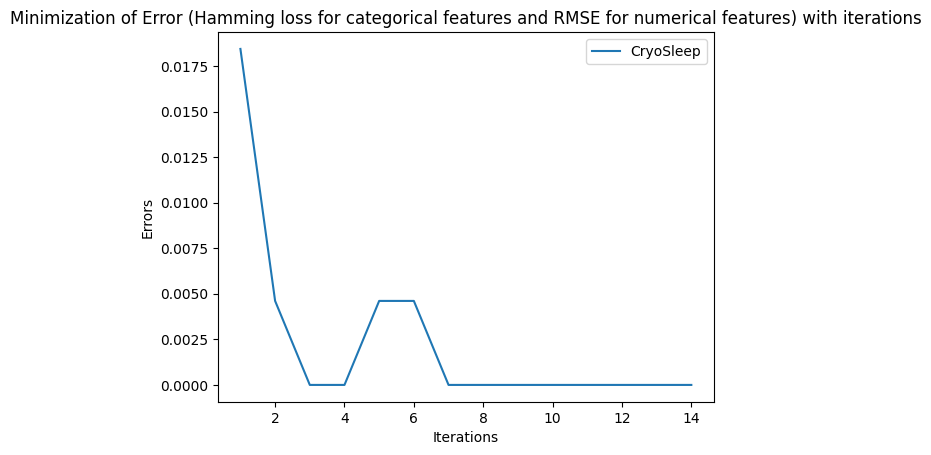

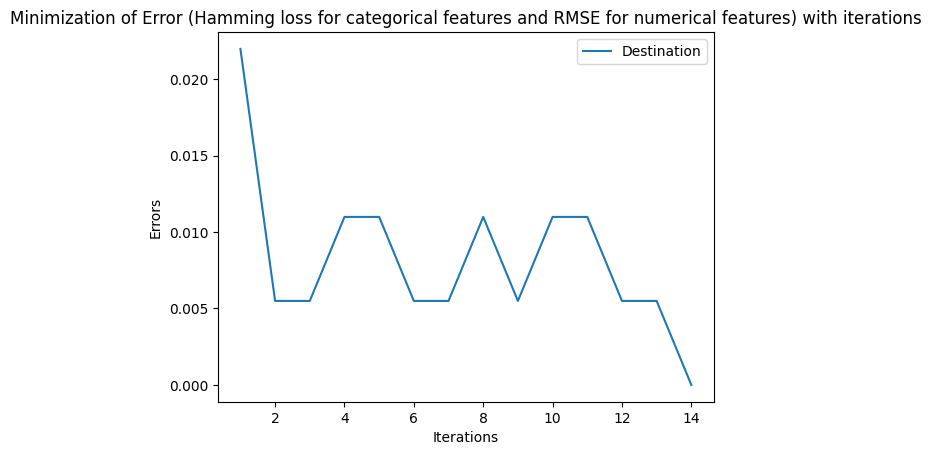

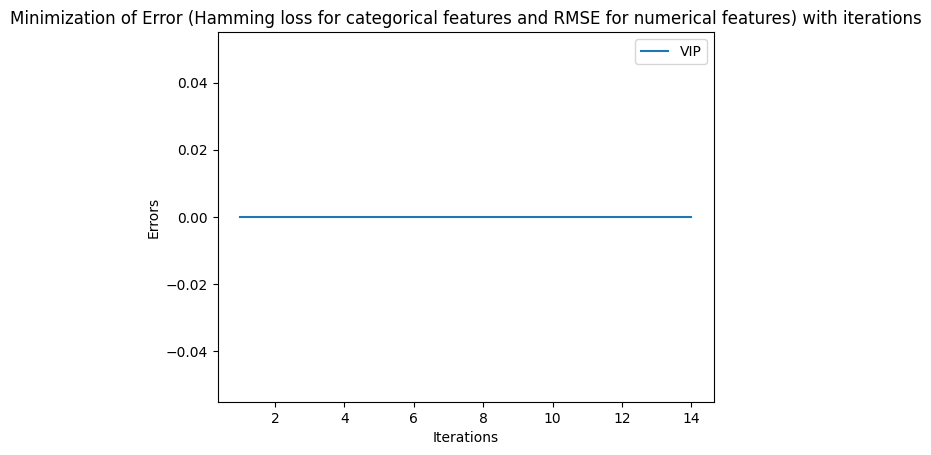

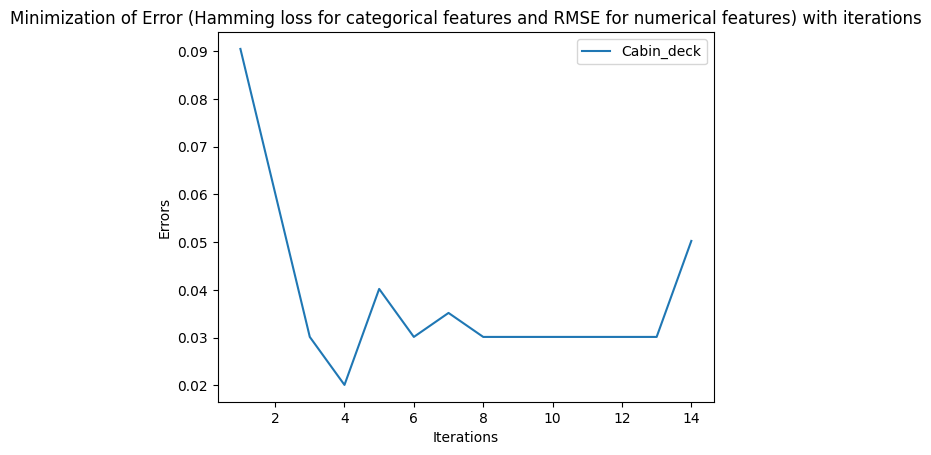

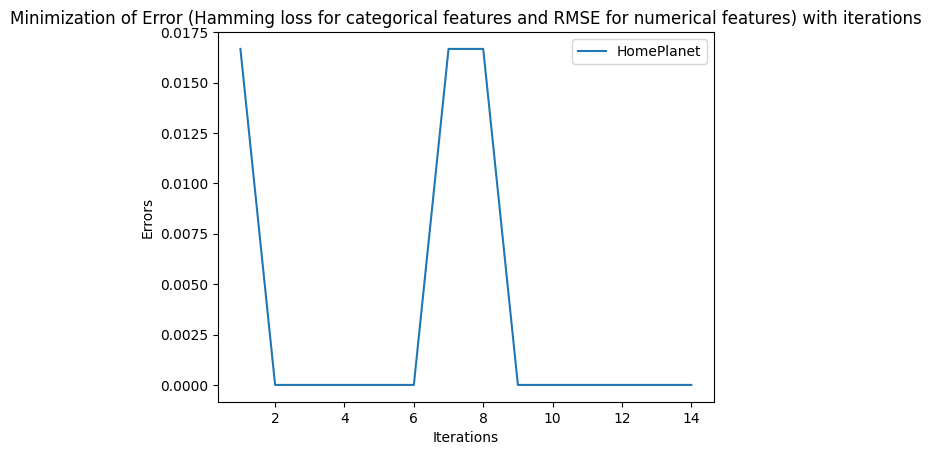

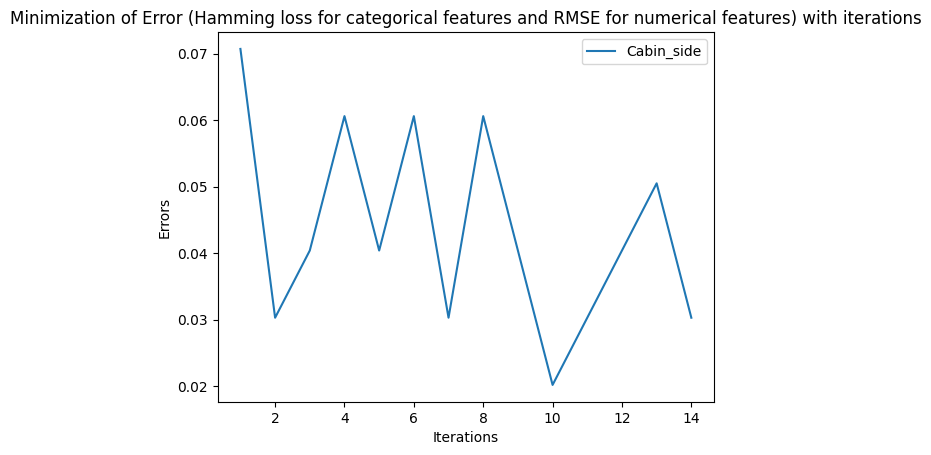

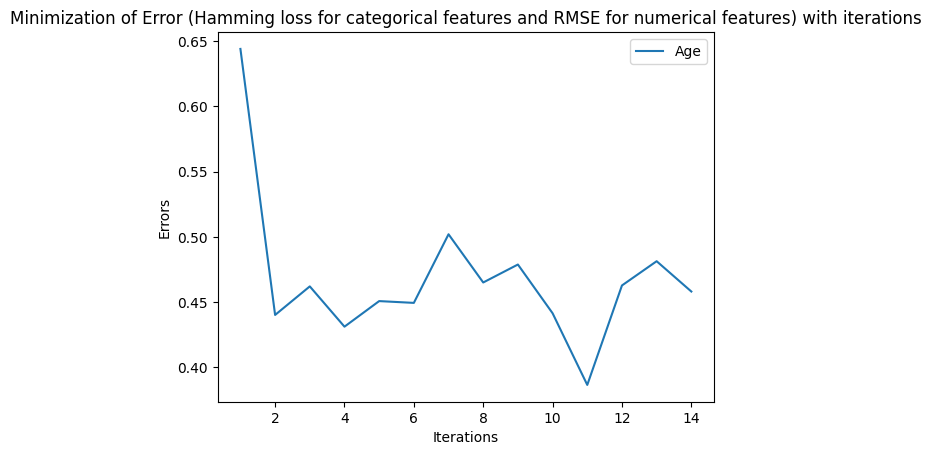

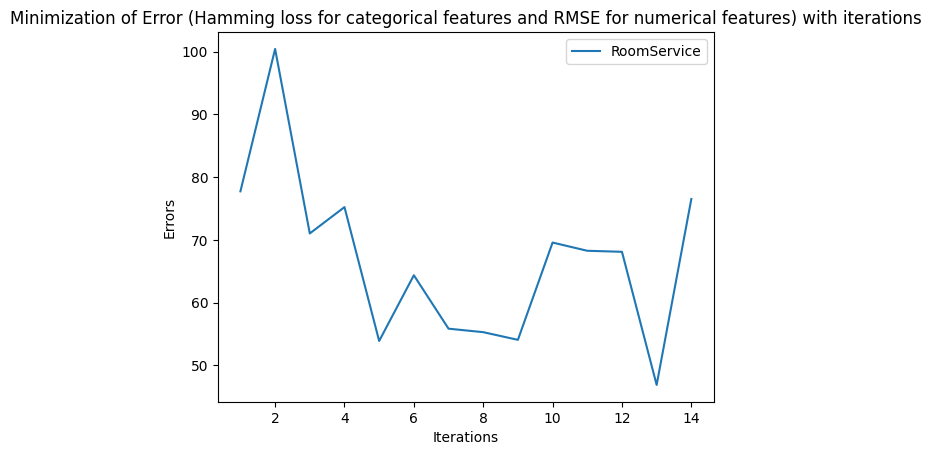

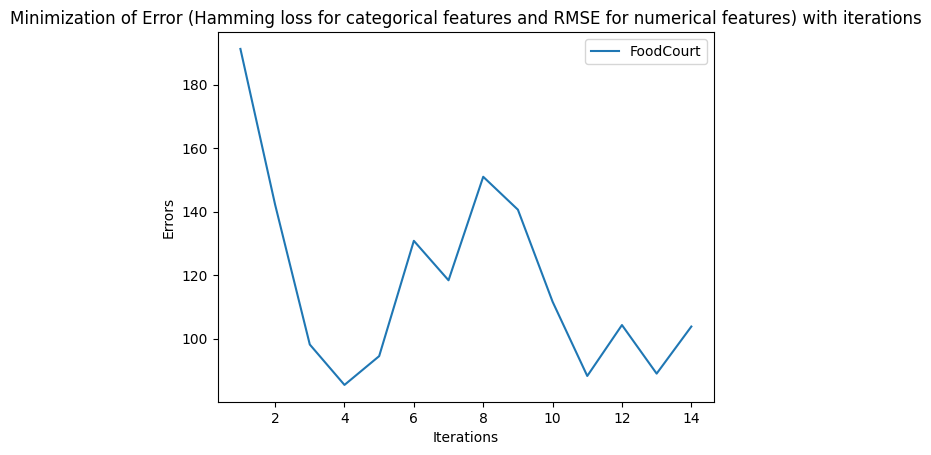

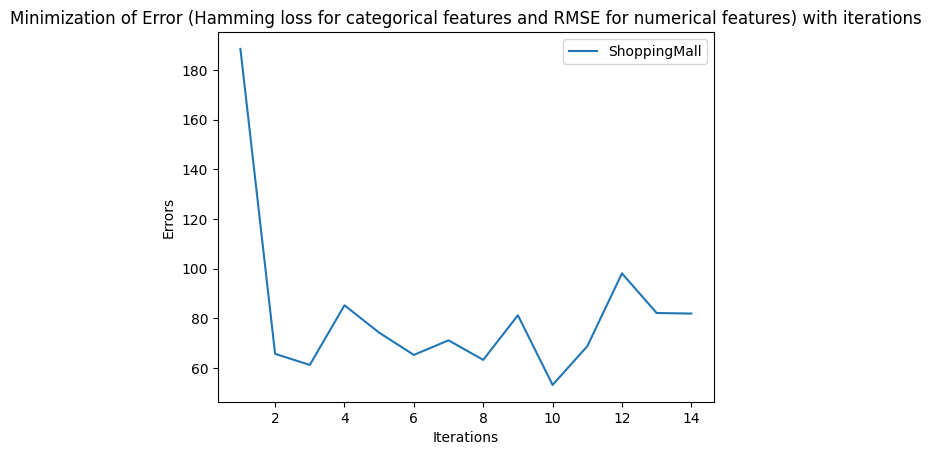

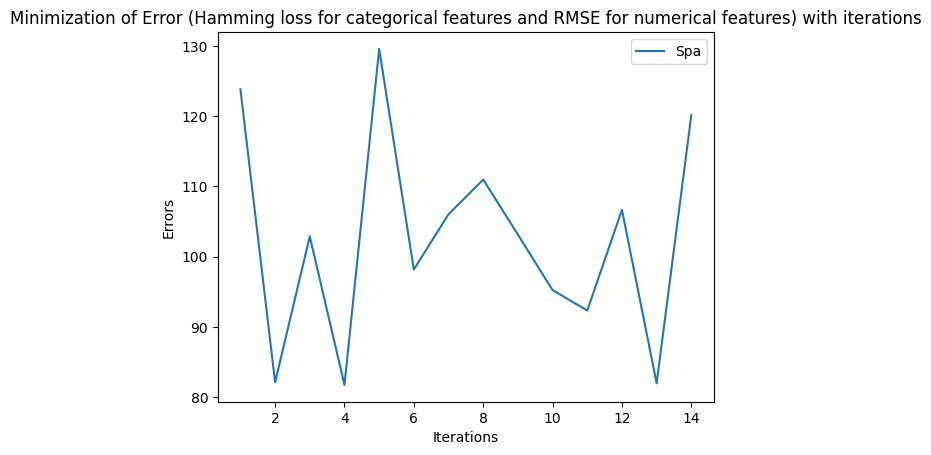

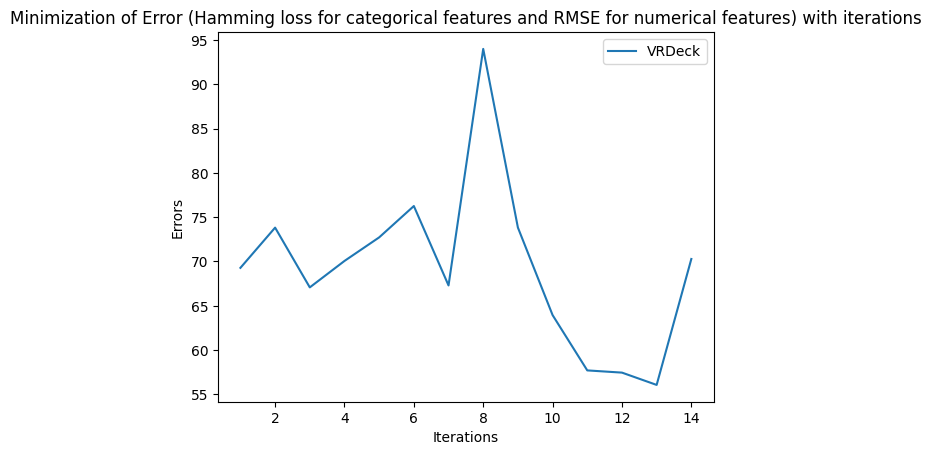

In [34]:
Imputer.plot_training_error()

In [35]:
Imputer_final = iter_cv_catboost_imputer(label="Transported", max_iter=5)

In [2]:
df_train = pd.read_csv("../data/EDA_export/train.csv")
df_test = pd.read_csv("../data/EDA_export/test.csv")

In [3]:
df_train_imp = pd.read_csv("../data/imputed/train.csv")
df_test_imp = pd.read_csv("../data/imputed/test.csv")

In [4]:
original_report = ProfileReport(df_train, title='Before imputation')

In [5]:
transformed_report = ProfileReport(df_train_imp, title="After imputation")

In [8]:
comparison_report = original_report.compare(transformed_report)
comparison_report.to_file("Before_vs_After_imp.html") 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
original_report_test = ProfileReport(df_test, title='Before imputation test')

In [7]:
transformed_report_test = ProfileReport(df_test_imp, title="After imputation_test")

In [8]:
comparison_report_test = original_report_test .compare(transformed_report_test )
comparison_report_test .to_file("Before_vs_After_test _imp.html") 

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
df_train[expenses] = df_train[expenses].clip(lower=0)
df_test[expenses] = df_test[expenses].clip(lower=0)

In [13]:
df_test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,ID_group,ID_num,Group_size
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000,4277.000000,4277.000000,4277.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031,4639.296469,1.498714,1.997428
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742,2716.197368,1.018221,1.537113
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.000000,1.000000,1.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2249.000000,1.000000,1.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4639.000000,1.000000,1.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000,7030.000000,2.000000,2.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000,9277.000000,8.000000,8.000000


In [15]:
df_train.to_csv('../data/imputed/train.csv')
df_test.to_csv('../data/imputed/test.csv')

In [16]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,ID_group,ID_num,Group_size
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624,4633.389624,1.517773,2.035546
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016,2671.028856,1.054241,1.596347
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2319.000000,1.000000,1.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4630.000000,1.000000,1.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000,6883.000000,2.000000,3.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,9280.000000,8.000000,8.000000


In [17]:
df_train.isna().sum()

HomePlanet      201
CryoSleep       217
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Transported       0
Cabin_deck      199
Cabin_side      199
ID_group          0
ID_num            0
Group_size        0
dtype: int64